In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from urllib.request import urlretrieve
import os
from network_deconvolution import network_deconvolution


def load_datasets():
    """加载并处理多个数据集,生成邻接矩阵并保存"""
    # 处理CORA数据集
    cora_dir = "cora"
    if os.path.exists(cora_dir):
        cora_citations = pd.read_csv(os.path.join(cora_dir, "cora.cites"), sep='\t', names=['cited_paper', 'citing_paper'])
        cora_content = pd.read_csv(os.path.join(cora_dir, "cora.content"), sep='\t', header=None)
        cora_papers = cora_content[0]
        cora_adj = create_adj_matrix(cora_papers, cora_citations)
        np.save(os.path.join(cora_dir, 'adj_matrix.npy'), cora_adj)
    # 处理Polbooks数据集
    polbooks_dir = "polbooks"
    if os.path.exists(polbooks_dir):
        G = nx.read_gml(os.path.join(polbooks_dir, "polbooks.gml"))
        polbooks_adj = nx.to_numpy_array(G)
        np.save(os.path.join(polbooks_dir, 'adj_matrix.npy'), polbooks_adj)

    # 处理Citeseer数据集  cora与citeseer数据集的content结构不同   Citeseer 的 content 文件中包含不同类型的数据（字符串ID和数值特征）
    citeseer_dir = "citeseer" 
    if os.path.exists(citeseer_dir):
        citeseer_citations = pd.read_csv(os.path.join(citeseer_dir, "citeseer.cites"), 
                                       sep='\t', 
                                       names=['cited_paper', 'citing_paper'])
        citeseer_content = pd.read_csv(os.path.join(citeseer_dir, "citeseer.content"), 
                                     sep='\t', 
                                     header=None,
                                     low_memory=False)  # 添加low_memory参数为false  pandas会会一次性读取整个文件，避免类型推断的不一致性
        citeseer_papers = citeseer_content[0]
        citeseer_adj = create_adj_matrix(citeseer_papers, citeseer_citations)
        np.save(os.path.join(citeseer_dir, 'adj_matrix.npy'), citeseer_adj)

    # 处理Pubmed数据集
    pubmed_dir = "pubmed"
    if os.path.exists(pubmed_dir):
        try:
            # 读取引用关系数据
            pubmed_citations = pd.read_csv(
                os.path.join(pubmed_dir, "Pubmed-Diabetes.DIRECTED.cites.tab"),
                sep='\t', 
                skiprows=3,  # 跳过前3行头部信息
                names=['index', 'citing_paper', 'separator', 'cited_paper']
            )
            # 清理数据
            pubmed_citations['citing_paper'] = pubmed_citations['citing_paper'].str.replace('paper:', '')
            pubmed_citations['cited_paper'] = pubmed_citations['cited_paper'].str.replace('paper:', '')
            pubmed_citations = pubmed_citations[['citing_paper', 'cited_paper']]
            
            # 获取所有唯一的论文ID
            all_papers = pd.concat([
                pubmed_citations['citing_paper'],
                pubmed_citations['cited_paper']
            ]).unique()
            
            # 创建论文ID的Series
            pubmed_papers = pd.Series(all_papers)
            
            # 生成邻接矩阵
            pubmed_adj = create_adj_matrix(pubmed_papers, pubmed_citations)
            
            # 保存邻接矩阵
            np.save(os.path.join(pubmed_dir, 'adj_matrix.npy'), pubmed_adj)
            print(f"成功保存Pubmed邻接矩阵,形状为: {pubmed_adj.shape}")
            
        except Exception as e:
            print(f"处理Pubmed数据集时出错: {str(e)}")
    # 处理Football数据集
    football_dir = "football"
    if os.path.exists(football_dir):
        G = nx.read_gml(os.path.join(football_dir, "football.gml"))
        football_adj = nx.to_numpy_array(G)
        np.save(os.path.join(football_dir, 'adj_matrix.npy'), football_adj)
    


def create_adj_matrix(papers, citations):
    """
    创建邻接矩阵
    
    参数:
        papers: 包含所有论文ID的Series
        citations: 包含引用关系的DataFrame，有'cited_paper'和'citing_paper'两列
    
    返回:
        adj_matrix: numpy数组形式的邻接矩阵
    """
    # 创建论文ID到索引的映射
    paper_to_idx = {paper: idx for idx, paper in enumerate(papers)}
    
    # 初始化邻接矩阵
    n_papers = len(papers)
    adj_matrix = np.zeros((n_papers, n_papers))
    
    # 填充邻接矩阵
    for _, row in citations.iterrows():
        try:
            citing_idx = paper_to_idx[row['citing_paper']]
            cited_idx = paper_to_idx[row['cited_paper']]
            # 设置为无向图（双向连接）
            adj_matrix[citing_idx, cited_idx] = 1
            adj_matrix[cited_idx, citing_idx] = 1
        except KeyError:
            # 跳过在papers列表中不存在的引用关系
            continue
    
    return adj_matrix




In [ ]:


def save_labels():
    """保存各个数据集的标签信息"""
    for dataset in ['cora', 'citeseer', 'pubmed', 'football', 'polbooks']:
        print(f"\n处理{dataset}数据集...")
        try:
            if not os.path.exists(dataset):
                print(f"警告：{dataset}目录不存在")
                continue
                
            if dataset == 'cora':
                # 确保文件存在
                content_file = os.path.join(dataset, 'cora.content')
                if not os.path.isfile(content_file):
                    print(f"错误：找不到文件 {content_file}")
                    continue
                    
                cora_labels = pd.read_csv(content_file, sep='\t', header=None).iloc[:, -1]
                unique_labels = cora_labels.unique()
                label_dict = {label: i for i, label in enumerate(unique_labels)}
                numeric_labels = np.array([label_dict[label] for label in cora_labels])
                np.save(os.path.join(dataset, 'labels.npy'), numeric_labels)
                print(f"成功保存{dataset}标签，共{len(unique_labels)}个类别")
                
            elif dataset == 'citeseer':
                content_file = os.path.join(dataset, 'citeseer.content')
                if not os.path.isfile(content_file):
                    print(f"错误：找不到文件 {content_file}")
                    continue
                    
                citeseer_labels = pd.read_csv(content_file, sep='\t', header=None).iloc[:, -1]
                unique_labels = citeseer_labels.unique()
                label_dict = {label: i for i, label in enumerate(unique_labels)}
                numeric_labels = np.array([label_dict[label] for label in citeseer_labels])
                np.save(os.path.join(dataset, 'labels.npy'), numeric_labels)
                print(f"成功保存{dataset}标签，共{len(unique_labels)}个类别")

            elif dataset == 'pubmed':
                label_file = os.path.join(dataset, 'Pubmed-Diabetes.NODE.paper.tab')
                if not os.path.isfile(label_file):
                    print(f"错误：找不到文件 {label_file}")
                    continue
                    
                try:
                    labels = []
                    with open(label_file, 'r', encoding='utf-8') as f:
                        header = next(f)  # 跳过头部行
                        for line in f:
                            if line.strip():  # 确保不是空行
                                parts = line.strip().split('\t')
                                # 在每行中寻找包含"label="的字段
                                for part in parts:
                                    if 'label=' in part:
                                        label = int(part.split('label=')[1])
                                        labels.append(label)
                                        break
                    
                    labels = np.array(labels)
                    unique_labels = np.unique(labels)
                    print(f"找到的标签值:", unique_labels)
                    print(f"标签总数:", len(labels))
                    print(f"各标签的数量:")
                    for label in unique_labels:
                        count = np.sum(labels == label)
                        print(f"标签 {label}: {count} 个")
                    
                    np.save(os.path.join(dataset, 'labels.npy'), labels)
                    print(f"成功保存{dataset}标签，共{len(unique_labels)}个类别")
                    
                except Exception as e:
                    print(f"处理{dataset}数据集时出错:", str(e))
                    continue

            elif dataset in ['football', 'polbooks']:
                gml_file = os.path.join(dataset, f'{dataset}.gml')
                if not os.path.isfile(gml_file):
                    print(f"错误：找不到文件 {gml_file}")
                    continue
                    
                G = nx.read_gml(gml_file)
                labels = [G.nodes[node]['value'] for node in G.nodes()]
                
                if dataset == 'polbooks':
                    label_map = {'c': 0, 'n': 1, 'l': 2}
                    labels = [label_map[label] for label in labels]
                    
                np.save(os.path.join(dataset, 'labels.npy'), np.array(labels))
                print(f"成功保存{dataset}标签")
                
        except Exception as e:
            print(f"处理{dataset}数据集时出错: {str(e)}")
            print(f"错误类型: {type(e).__name__}")
            continue

save_labels()

In [ ]:
#  数据集信息汇总： 
#  football ： 关于足球的数据集，代表了某一次的比赛安排，共115个节点表示每个球队，节点按照地理位置背分为12个会议，
#   如果两个球队之间进行了比赛，就会有一条边连接，共613条边    12个会议形成了自然的社区 
#  Cora:  机器学习论文的引用网络，2708个节点，每个节点表示一篇论文，5429条边表示引用关系，每个节点有1433维的特征向量，是词袋表示， 
#   每个节点属于7个类别之一（论文主题）
#  Citeseer： 来自citeseer图书馆的文献引用网络，3312个节点（论文），4732条边（引用关系），每个节点3703维的特征向量，分为6个类别
#  Pubmed： 来自pubmed的文献引用网络，19717个节点（论文），44338条边（引用关系），每个节点500维的特征向量，分为3个类别
#  Polbooks：2004年美国总统大选期间亚马逊网站上的政治书籍购买网络 105个节点（表示书籍），边441条表示共同购买关系，分为保守派、自由派、中立派
#  3种类别
# 
# 

import numpy as np
datasets = ['cora', 'citeseer', 'pubmed', 'football', 'polbooks'] # citeseer的边数可能不对

for dataset in datasets:
    # 加载邻接矩阵
    adj_matrix = np.load(f'{dataset}/adj_matrix.npy')
    print(f"\n{dataset.upper()} 统计信息:")
    # 1. 查看矩阵基本信息
    print(f"矩阵形状: {adj_matrix.shape}")
    print(f"矩阵类型: {adj_matrix.dtype}")

    # 2. 查看矩阵的一小部分
    print("\n矩阵的前5x5部分:")
    print(adj_matrix[:5, :5])

    # 3. 查看一些基本统计信息
    print(f"\n非零元素数量: {np.count_nonzero(adj_matrix)}")
    print(f"最大值: {np.max(adj_matrix)}")
    print(f"最小值: {np.min(adj_matrix)}")

    # 4. 如果想查看是否为对称矩阵
    is_symmetric = np.allclose(adj_matrix, adj_matrix.T)
    print(f"\n是否为对称矩阵: {is_symmetric}")

Cora原始数据集邻接矩阵形状: (2708, 2708)
Citeseer原始数据集邻接矩阵形状: (3312, 3312)
Political Books原始数据集邻接矩阵形状: (105, 105)
Football原始数据集邻接矩阵形状: (115, 115)

处理数据集: Cora


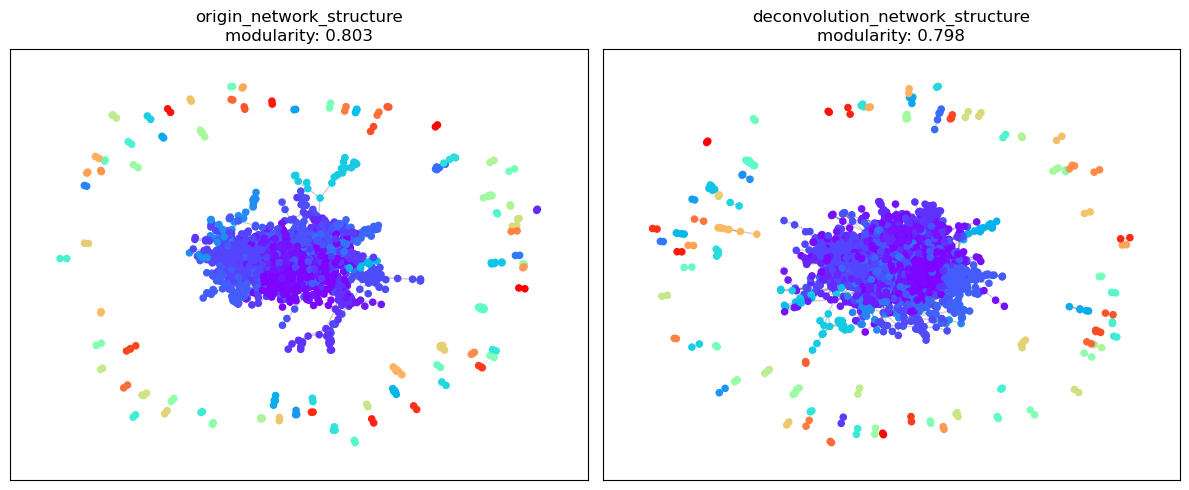

原始网络社团数量: 93
解卷积后网络社团数量: 94

处理数据集: Citeseer


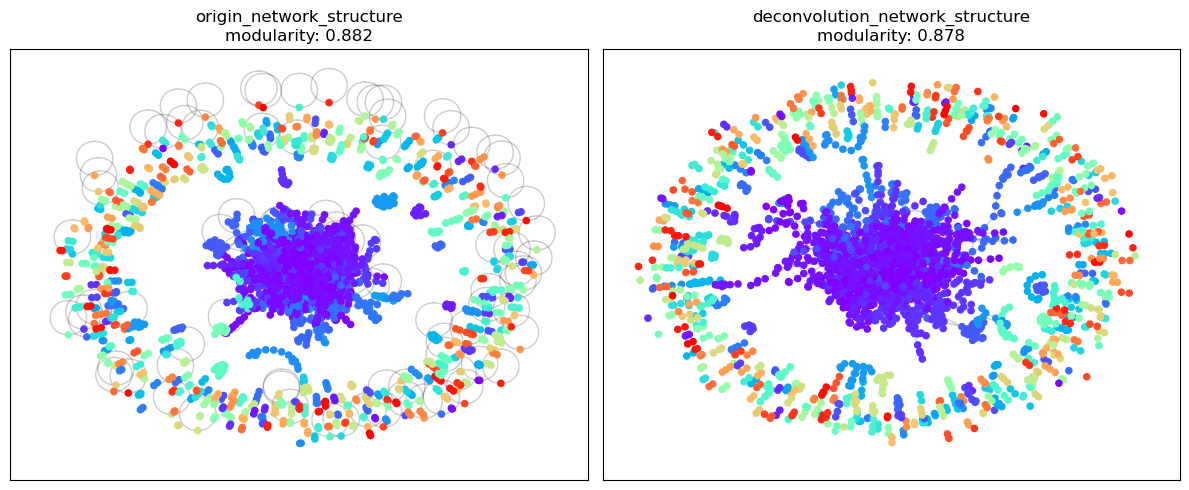

原始网络社团数量: 458
解卷积后网络社团数量: 458

处理数据集: Political Books


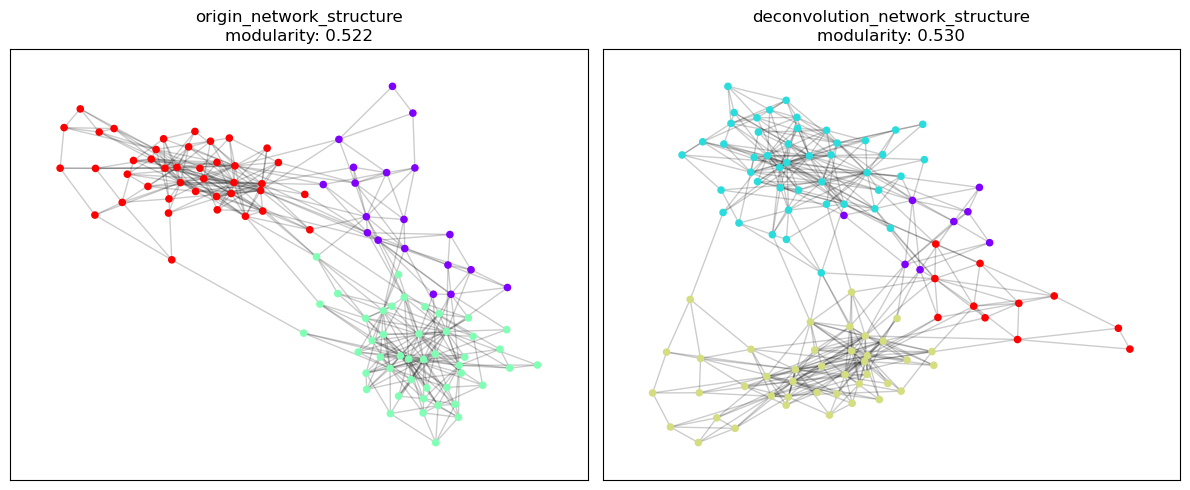

原始网络社团数量: 3
解卷积后网络社团数量: 4

处理数据集: Football


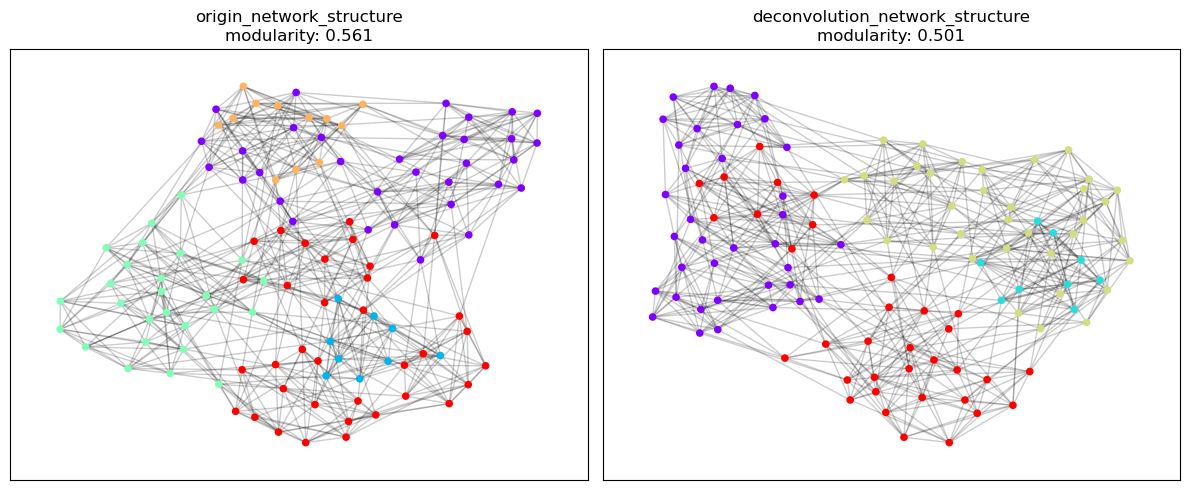

原始网络社团数量: 5
解卷积后网络社团数量: 4


In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import networkx as nx
from urllib.request import urlretrieve
import os
from network_deconvolution import network_deconvolution

# 主程序
def main():
    # 加载并处理数据
    datasets = {
        'Cora': 'cora/adj_matrix.npy',
        'Citeseer': 'citeseer/adj_matrix.npy', 
        'Political Books': 'polbooks/adj_matrix.npy',
        # 'Pubmed': 'pubmed/adj_matrix.npy',
        'Football': 'football/adj_matrix.npy'
    }
    
    # 读取所有数据集的邻接矩阵
    adj_matrices = {}
    for name, path in datasets.items():
        adj_matrices[name] = np.load(path)
        print(f"{name}原始数据集邻接矩阵形状: {adj_matrices[name].shape}")

    # 递归处理所有数据集
    results = {}
    for dataset_name, adj_matrix in adj_matrices.items():
        print(f"\n处理数据集: {dataset_name}")
        
        # 将邻接矩阵转换为相似度矩阵
        row_sums = adj_matrix.sum(axis=1)
        row_sums[row_sums == 0] = 1  # 避免除以0
        norm_adj_matrix = adj_matrix / row_sums[:, np.newaxis]
        
        # 应用网络解卷积
        deconv_matrix = network_deconvolution(norm_adj_matrix, beta=0.9, alpha=0.8)
        results[dataset_name] = deconv_matrix
        
        # 打印统计信息
        # print(f"解卷积后矩阵的形状: {deconv_matrix.shape}")
        # print(f"非零元素数量: {np.count_nonzero(deconv_matrix)}")
        # print(f"最大值: {np.max(deconv_matrix):.4f}")
        # print(f"最小值: {np.min(deconv_matrix):.4f}")
        # print(f"平均值: {np.mean(deconv_matrix):.4f}")
        
        # 进行社团检测分析
        try:
            original_communities, deconv_communities = analyze_results(adj_matrix, deconv_matrix)
            
            # # 打印社团信息
            # print("\n社团大小分布:")
            # print("原始网络:")
            # for community_id in set(original_communities.values()):
            #     size = list(original_communities.values()).count(community_id)
            #     print(f"社团 {community_id}: {size} 个节点")
                
            # print("\n解卷积后网络:")
            # for community_id in set(deconv_communities.values()):
            #     size = list(deconv_communities.values()).count(community_id)
            #     print(f"社团 {community_id}: {size} 个节点")
        except Exception as e:
            print(f"社团检测分析失败: {str(e)}")
            continue
            
    return results

# 分析结果
def analyze_results(original_matrix, deconv_matrix):
    """
    分析原始邻接矩阵和解卷积后的邻接矩阵,并进行社团检测
    
    参数:
        original_matrix: 原始邻接矩阵
        deconv_matrix: 解卷积后的邻接矩阵
        
    返回:
        original_communities: 原始网络的社团划分结果
        deconv_communities: 解卷积网络的社团划分结果
    """
    import networkx as nx
    from community import community_louvain
    import matplotlib.pyplot as plt
    from sklearn.metrics.cluster import normalized_mutual_info_score
    
    # 将邻接矩阵转换为NetworkX图
    G_original = nx.from_numpy_array(original_matrix)
    G_deconv = nx.from_numpy_array(deconv_matrix)
    
    # 使用Louvain算法进行社团检测
    original_communities = community_louvain.best_partition(G_original, resolution=2.0)
    deconv_communities = community_louvain.best_partition(G_deconv, resolution=2.0)
    
    # 计算模块度
    original_modularity = community_louvain.modularity(original_communities, G_original)
    deconv_modularity = community_louvain.modularity(deconv_communities, G_deconv)
    
    # 可视化结果
    plt.figure(figsize=(12, 5))
    
    # 绘制原始网络社团结构
    plt.subplot(121)
    pos_original = nx.spring_layout(G_original)
    nx.draw_networkx_nodes(G_original, pos_original, node_color=list(original_communities.values()),
                          cmap=plt.cm.rainbow, node_size=20)
    nx.draw_networkx_edges(G_original, pos_original, alpha=0.2)
    plt.title(f'origin_network_structure\nmodularity: {original_modularity:.3f}')
    
    # 绘制解卷积后网络社团结构
    plt.subplot(122)
    pos_deconv = nx.spring_layout(G_deconv)
    nx.draw_networkx_nodes(G_deconv, pos_deconv, node_color=list(deconv_communities.values()),
                          cmap=plt.cm.rainbow, node_size=20)
    nx.draw_networkx_edges(G_deconv, pos_deconv, alpha=0.2)
    plt.title(f'deconvolution_network_structure\nmodularity: {deconv_modularity:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # 打印社团统计信息
    print(f'原始网络社团数量: {len(set(original_communities.values()))}')
    print(f'解卷积后网络社团数量: {len(set(deconv_communities.values()))}')
    
    return original_communities, deconv_communities

if __name__ == "__main__":
    results = main()